In [1]:
import pandas as pd       
from bs4 import BeautifulSoup     
import re
import warnings
warnings.filterwarnings('ignore')

import nltk # Download text data sets, including stop words
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Tools for preprocessing input data
from bs4 import BeautifulSoup
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Tools for creating ngrams and vectorizing input data
from gensim.models import Word2Vec, Phrases
from gensim.models import KeyedVectors

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D


Using TensorFlow backend.


In [2]:
# Read data from the CSV into a dataframe


train_data = pd.read_csv("imdb_master.csv", encoding="latin-1")

test_data = pd.read_csv("testData.tsv", header=0, \
                    delimiter="\t", quoting=3)


In [3]:
train_data.shape

(100000, 5)

In [4]:
train_data.label.value_counts()

unsup    50000
neg      25000
pos      25000
Name: label, dtype: int64

In [5]:
# Prepare the second data set to combine it with first one
train_data['sentiment'] = train_data['label']
train_data = train_data[['review', 'sentiment']]
train_data = train_data.loc[train_data.sentiment != 'unsup']
train_data['sentiment'] = train_data['sentiment'].map(lambda x : 1 if x == 'pos' else 0)

In [6]:
train_data.head()

,review,sentiment
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures (movies is not a fitting word f...,0


In [7]:
# data set size
train_data.shape

(50000, 2)

In [8]:
# Number of sentiment values
train_data.sentiment.value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

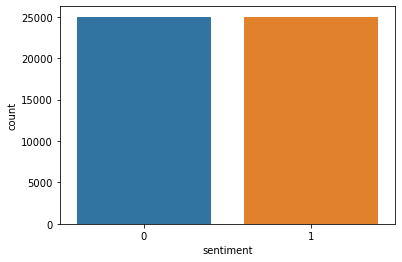

In [9]:
ax = sns.countplot(x="sentiment", data=train_data)

In [10]:
#https://www.kaggle.com/c/word2vec-nlp-tutorial/overview/part-1-for-beginners-bag-of-words
def review_to_wordlist(review, remove_stopwords=False ):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(review).get_text()
    #  
    # 2. Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    #
    # 3. Convert words to lower case and split them
    words = review_text.lower().split()
    #
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    #
    # 5. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( words )) 

def lemmatize(tokens: list) -> list:
    lemmatizer = WordNetLemmatizer()
    tokens = list(map(lemmatizer.lemmatize, tokens))
    lemmatized_tokens = list(map(lambda x: lemmatizer.lemmatize(x, "v"), tokens))
    return (lemmatized_tokens)
    

def preprocess(review: str):
    # 1. Clean text
    review = review_to_wordlist(review)
    # 2. Split into individual words
    tokens = word_tokenize(review)
    # 3. Lemmatize
    lemmas = lemmatize(tokens)
    # 4. Join the words back into one string separated by space,
    # and return the result.
    return( " ".join( lemmas )) 


In [11]:
train_data['clean_review'] = train_data['review'].apply(preprocess)
train_data = train_data.drop_duplicates('clean_review')

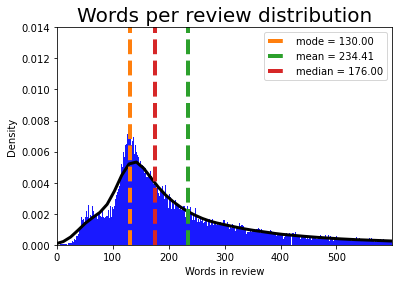

In [12]:
train_data['review_length'] = train_data['clean_review'].str.split().str.len()
median = train_data['review_length'].median()
mean = train_data['review_length'].mean()
mode = train_data['review_length'].mode()[0]
fig, ax = plt.subplots()
sns.distplot(train_data['review_length'], bins=train_data['review_length'].max(),
            hist_kws={"alpha": 0.9, "color": "blue"}, ax=ax,
            kde_kws={"color": "black", 'linewidth': 3})
ax.set_xlim(left=0, right=np.percentile(train_data['review_length'], 95))
ax.set_xlabel('Words in review')
ymax = 0.014
plt.ylim(0, ymax)
ax.plot([mode, mode], [0, ymax], '--', label=f'mode = {mode:.2f}', linewidth=4)
ax.plot([mean, mean], [0, ymax], '--', label=f'mean = {mean:.2f}', linewidth=4)
ax.plot([median, median], [0, ymax], '--',
        label=f'median = {median:.2f}', linewidth=4)
ax.set_title('Words per review distribution', fontsize=20)
plt.legend()
plt.show()

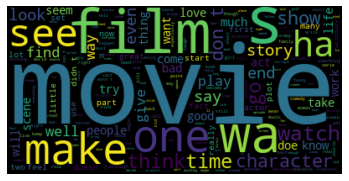

In [13]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(' '.join(train_data['clean_review']))
#wordcloud = WordCloud().generate(train_data['clean_review'])

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Modeling

In [14]:
X_train = train_data['clean_review']
y_train = train_data.sentiment

In [15]:
# Set sequence_length to the median of review 
sequence_length = train_data['review_length'].median()

In [16]:
max_features = 35000 # this is the number of words we care about

reviews = train_data['clean_review'].values

tokenizer = Tokenizer(num_words = max_features, split=' ', oov_token='<unw>')
tokenizer.fit_on_texts(reviews)

# this takes our sentences and replaces each word with an integer
X = tokenizer.texts_to_sequences(reviews)


In [17]:
# we then pad the sequences so they're all the same length (sequence_length)
X = pad_sequences(X, int(sequence_length))

y = train_data['sentiment']

# where there isn't a test set, Kim keeps back 10% of the data for testing, I'm going to do the same since we have an ok amount to play with
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

print("validation testset size " + str(len(X_test)))

validation testset size 4958


In [18]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 82016 unique tokens.


In [19]:
# Load vectors directly from the file
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

embedding_matrix = np.zeros((len(word_index) + 1, model.vector_size))
for word, i in word_index.items():
    try:
        embedding_vector = model.get_vector(word)
        embedding_matrix[i] = embedding_vector
    except:
        pass
    
embedding_dim = 300       

In [20]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim = embedding_matrix.shape[0], output_dim = embedding_matrix.shape[1], 
                            weights=[embedding_matrix],input_length = sequence_length))
model_lstm.add(Bidirectional(LSTM(32,dropout=0.5, return_sequences = False)))
model_lstm.add(Dense(1, activation="sigmoid"))
model_lstm.compile(
    loss='binary_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)
model_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 176.0, 300)        24605100  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                85248     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 24,690,413
Trainable params: 24,690,413
Non-trainable params: 0
_________________________________________________________________


## Training

In [21]:
history = model_lstm.fit(X_train, y_train, epochs = 3, batch_size = 256, verbose = 1, validation_split = 0.1, shuffle = True)

Train on 40157 samples, validate on 4462 samples
Epoch 1/3
40157/40157 [==============================] - 306s 8ms/step - loss: 0.5175 - acc: 0.7368 - val_loss: 0.3492 - val_acc: 0.8543
Epoch 2/3
40157/40157 [==============================] - 339s 8ms/step - loss: 0.3215 - acc: 0.8658 - val_loss: 0.3204 - val_acc: 0.8675
Epoch 3/3
40157/40157 [==============================] - 327s 8ms/step - loss: 0.2548 - acc: 0.8994 - val_loss: 0.2908 - val_acc: 0.8841


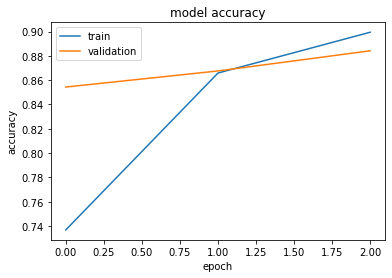

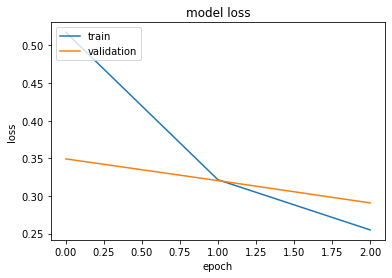

In [22]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [23]:
# Set predictions with thersohld 0.5
y_lstm_pred = model_lstm.predict(X_test)
y_pred = (y_lstm_pred > 0.5)

In [24]:
print(classification_report(y_test, y_pred, ))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      2439
           1       0.91      0.87      0.89      2519

   micro avg       0.89      0.89      0.89      4958
   macro avg       0.89      0.89      0.89      4958
weighted avg       0.89      0.89      0.89      4958



<AxesSubplot:>

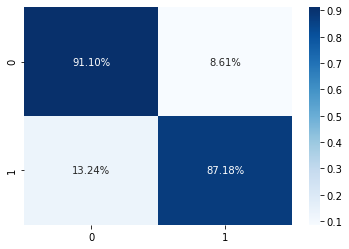

In [25]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix, axis = 1), annot=True, 
            fmt='.2%', cmap='Blues')


# Test Set Evalutaion

In [26]:
# Extract sentiment value from ID
test_data["sentiment"] = test_data["id"].map(lambda x: 1 if int(x.strip('"').split("_")[1]) >= 5 else 0)
y_test = test_data["sentiment"]

#Preprocessing
test_data["clean_review"]= test_data['review'].apply(review_to_wordlist)

list_sentences_test = test_data["clean_review"]
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_te = pad_sequences(list_tokenized_test, maxlen=int(sequence_length))
prediction = model_lstm.predict(X_te)
y_pred = (prediction > 0.5)

In [27]:
print(classification_report(y_test, y_pred, ))

              precision    recall  f1-score   support

           0       0.95      0.82      0.88     12500
           1       0.84      0.96      0.90     12500

   micro avg       0.89      0.89      0.89     25000
   macro avg       0.90      0.89      0.89     25000
weighted avg       0.90      0.89      0.89     25000



<AxesSubplot:>

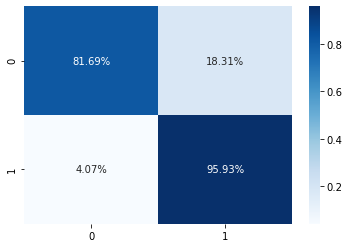

In [28]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix, axis = 1), annot=True, 
            fmt='.2%', cmap='Blues')
